In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01531178', '/kaggle/input/islvrc-2012-10-pecent-subset/n01

In [4]:
import torch
import os
import PIL
from torch import nn
import torch.optim as optim
!pip install torchsummary

# for dirname, _, filenames in os.walk('/kaggle/input/islvrc-2012-10-pecent-subset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [5]:
alexnet = nn.Sequential( 
    nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, stride = 4, padding=0),  # (96, ((227-11+2*0)/4) +1 =55, 55)
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride =2),  # z = 3, s =2
    nn.LocalResponseNorm(size=5), # (96, 27, 27)
    

    nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding=2),  # (256, 27, 27)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride =2),  
    nn.LocalResponseNorm(size=5), # (256, 13, 13)

    nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding=1),
    nn.ReLU(),

    nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding=1),
    nn.ReLU(),

    nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride =2), 
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features = 6*6*256,out_features= 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features =4096,out_features= 4096),
    nn.ReLU(),
    nn.Linear(in_features =4096,out_features= 1000)
)

# alexnet.add(Softmax())

In [33]:
from torchsummary import summary


device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")
alexnet.to(device)
summary(alexnet, input_size = (3, 227, 227), device='cuda')

device:cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
 LocalResponseNorm-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
 LocalResponseNorm-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14       

In [44]:
optimizer = optim.SGD(alexnet.parameters(), lr = 0.0005, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [14]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),  # image/numpy를 tensor로 변환 
    transforms.Resize(256),
    transforms.RandomCrop(227),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


In [15]:
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets

train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/islvrc-2012-10-pecent-subset',
                                                transform = train_transform)

In [35]:
import numpy as np

dataset_len = len(train_dataset)
indices = list(range(dataset_len))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:round(dataset_len*0.9)], indices[round(dataset_len*0.9):] 

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size = 256 ,
                                                sampler= train_indices,
                                                num_workers =4)

val_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                batch_size = 256,
                                                sampler= val_indices,
                                                num_workers =4)

In [36]:
import matplotlib
import matplotlib.pyplot as plt

classes = []

# for dirname, _, filenames in os.walk('/kaggle/input/islvrc-2012-10-pecent-subset'):
#     for filename in filenames:
#         classes.append(dirname)
        # print(dirname)

classes = os.listdir('/kaggle/input/islvrc-2012-10-pecent-subset')


data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# def print_image(image):
#     x = image/2 +0.5 #reverse normalization
#     np_image = x.numpy() #convert to numpy for plt viz
#     plt.imshow(np.transpose(np_image, (1, 2, 0))) #transpose to convert from tensor to numpy


# # show images
# print_image(torchvision.utils.make_grid(images[:5, :, :]))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [54]:
from tqdm import tqdm

epoch = 10
train_losses = []
avg_trainlosses = [] 
avg_vallosses = []

for ep in range(epoch):
    print(f"epoch : {ep}")

    for i, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        optimizer.zero_grad()
        
        images, labels = batch
        images = images.cuda()
        labels = labels.cuda()
        
        output = alexnet(images)
        loss = loss_fn(output, labels)
        # print(f"loss: {loss}")
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    avg_trainloss = np.average(train_losses)

    alexnet.eval()
    val_losses = []
    
    with torch.no_grad():
        for data in val_dataloader:
            val_images, val_labels = data
            val_images = val_images.cuda()
            val_labels = val_labels.cuda()
            output = alexnet(val_images)

            val_loss = loss_fn(output,val_labels)
            val_losses.append(val_loss.item())
            
        avg_valloss = np.average(val_losses)  
        avg_vallosses.append(avg_valloss)

    avg_trainlosses.append(avg_trainloss)
    
alexnet.load_state_dict(alexnet.state_dict(), 'weight.pth')

epoch : 0


100%|██████████| 451/451 [07:12<00:00,  1.04it/s]


epoch : 1


100%|██████████| 451/451 [07:13<00:00,  1.04it/s]


epoch : 2


100%|██████████| 451/451 [07:13<00:00,  1.04it/s]


epoch : 3


100%|██████████| 451/451 [07:07<00:00,  1.05it/s]


epoch : 4


100%|██████████| 451/451 [07:05<00:00,  1.06it/s]


epoch : 5


100%|██████████| 451/451 [07:08<00:00,  1.05it/s]


epoch : 6


100%|██████████| 451/451 [07:12<00:00,  1.04it/s]


epoch : 7


100%|██████████| 451/451 [07:11<00:00,  1.05it/s]


epoch : 8


100%|██████████| 451/451 [07:07<00:00,  1.05it/s]


epoch : 9


100%|██████████| 451/451 [07:07<00:00,  1.05it/s]


<All keys matched successfully>

In [55]:
import pandas as pd

trainloss_df = pd.DataFrame(avg_trainlosses, columns=['value'])
trainloss_df['type']='training_loss'
trainloss_df['epoch_num']=range(len(avg_trainlosses))
trainloss_df['epoch_num']=trainloss_df['epoch_num']+1
valloss_df = pd.DataFrame(avg_vallosses, columns=['value'])
valloss_df['type']='valid_loss'
valloss_df['epoch_num']=range(len(avg_vallosses))
valloss_df['epoch_num']=valloss_df['epoch_num']+1
combined_df = pd.concat([trainloss_df, valloss_df])
combined_df.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='epoch_num', ylabel='value'>

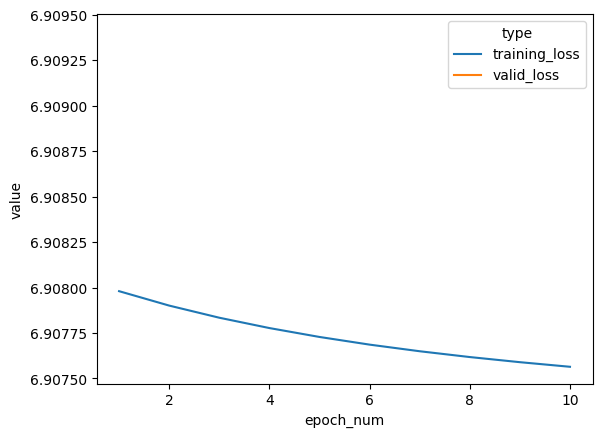

In [56]:
import seaborn as sns
sns.lineplot(data=combined_df,x='epoch_num', y='value', hue='type')